In [ ]:
# Mount Google Drive so the project data files can be accessed from Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
# Path to the project folder inside Google Drive
project_folder_path = '/content/drive/My Drive/Project_C4'

In [ ]:
# Load and prepare TEST dataset
df_test = pd.read_csv("/content/drive/My Drive/Project_C4/df_test.csv")
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.sort_values("date")


In [ ]:
# Load and prepare TRAIN dataset
df_train = pd.read_csv("/content/drive/My Drive/Project_C4/df_train.csv")
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.sort_values("date")

In [ ]:
# Prepare train and test datasets for modeling:
# - rename columns to standardized names (ds, y)
df_train = df_train.rename(columns={"date": "ds", "trips": "y"})
df_test  = df_test.rename(columns={"date": "ds", "trips": "y"})
# - convert date strings to datetime
df_train["ds"] = pd.to_datetime(df_train["ds"])
df_test["ds"]  = pd.to_datetime(df_test["ds"])

# - map season labels to numeric codes
seasons = {
    "Winter": 0,
    "Spring": 1,
    "Summer": 2,
    "Fall": 3
}

df_train['season'] = df_train['season'].map(seasons)
df_test['season']  = df_test['season'].map(seasons)



In [ ]:
# - add a split indicator
# - combine train and test into a single unified dataframe ordered by date
df_train["split"] = "train"
df_test["split"] = "test"

df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all = df_all.sort_values("ds").reset_index(drop=True)



In [ ]:
import numpy as np

def add_features(df):
    df = df.copy()

    # Basic time components
    df['day_of_week'] = df['ds'].dt.dayofweek
    df['month'] = df['ds'].dt.month
    df['day_of_year'] = df['ds'].dt.dayofyear

    # Fourier - weekly
    df['week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Fourier - yearly
    df['year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

    # Weather interactions
    df['rain_x_season'] = df['prcp'] * df['season']
    df['wind_x_season'] = df['wspd'] * df['season']
    df['temp_x_season'] = df['tavg'] * df['season']
    df['temp_x_month'] = df['tavg'] * df['month']

    # Lag
    df['y_lag1']  = df['y'].shift(1)
    df['y_lag7']  = df['y'].shift(7)
    df['y_lag30'] = df['y'].shift(30)
    df['y_lag90'] = df['y'].shift(90)


    return df

In [ ]:
# Convert selected columns to numeric, generate all model features
num_cols = ["tavg", "prcp", "wspd", "is_weekend", "season", "day_of_week"]

for c in num_cols:
    df_all[c] = pd.to_numeric(df_all[c], errors="coerce")

In [ ]:
# drop rows with missing values, and split the full dataset into
# training and test subsets based on the 'split' flag.
df_all = add_features(df_all)
df_all = df_all.dropna()


train = df_all[df_all["split"] == "train"].copy()
test = df_all[df_all["split"] == "test"].copy()

In [ ]:
# Select the feature columns (regressors) and split the data into training and test sets
regressors = [
    'day_of_week', 'month', 'day_of_year',
    'week_sin', 'week_cos',
    'year_sin', 'year_cos',
    'rain_x_season', 'wind_x_season',
    'temp_x_season', 'temp_x_month',
    'tavg', 'prcp', 'wspd', 'season',
    'y_lag1', 'y_lag7', 'y_lag30', 'y_lag90'
]

X_train = train[regressors]
y_train = train["y"]

X_test = test[regressors]
y_test = test["y"]


In [ ]:
from sklearn.linear_model import LinearRegression
# 1. Train Linear
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
# 2. Predict
test["yhat_linear"] = lin_model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# 3. Metrics
mae = mean_absolute_error(y_test, test["yhat_linear"])
rmse = mean_squared_error(y_test, test["yhat_linear"])**0.5
r2 = r2_score(y_test, test["yhat_linear"])

print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R²  :", round(r2, 4))


MAE : 12443.5962
RMSE: 16086.9004
R²  : 0.7763


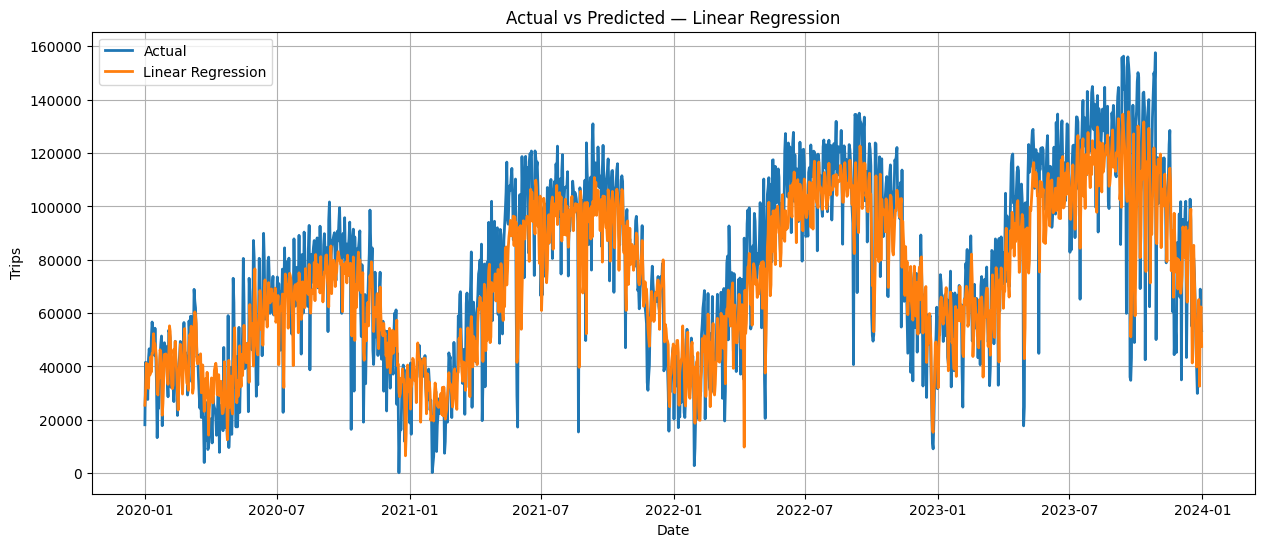

In [ ]:
import matplotlib.pyplot as plt
# 4. Plot: Actual vs Predicted

plt.figure(figsize=(15,6))
plt.plot(test["ds"], y_test, label="Actual", linewidth=2)
plt.plot(test["ds"], test["yhat_linear"], label="Linear Regression", linewidth=2)

plt.title("Actual vs Predicted — Linear Regression")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install xgboost


In [ ]:
from xgboost import XGBRegressor
# 1. Train XGBoost
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="reg:squarederror"
)

xgb_model.fit(X_train, y_train)

# 2. Predict
test["yhat_xgb"] = xgb_model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# 3. Metrics
mae = mean_absolute_error(y_test, test["yhat_xgb"])
rmse = mean_squared_error(y_test, test["yhat_xgb"])**0.5
r2 = r2_score(y_test, test["yhat_xgb"])

print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("R²  :", round(r2, 4))


MAE : 20128.2734
RMSE: 25625.4748
R²  : 0.4324


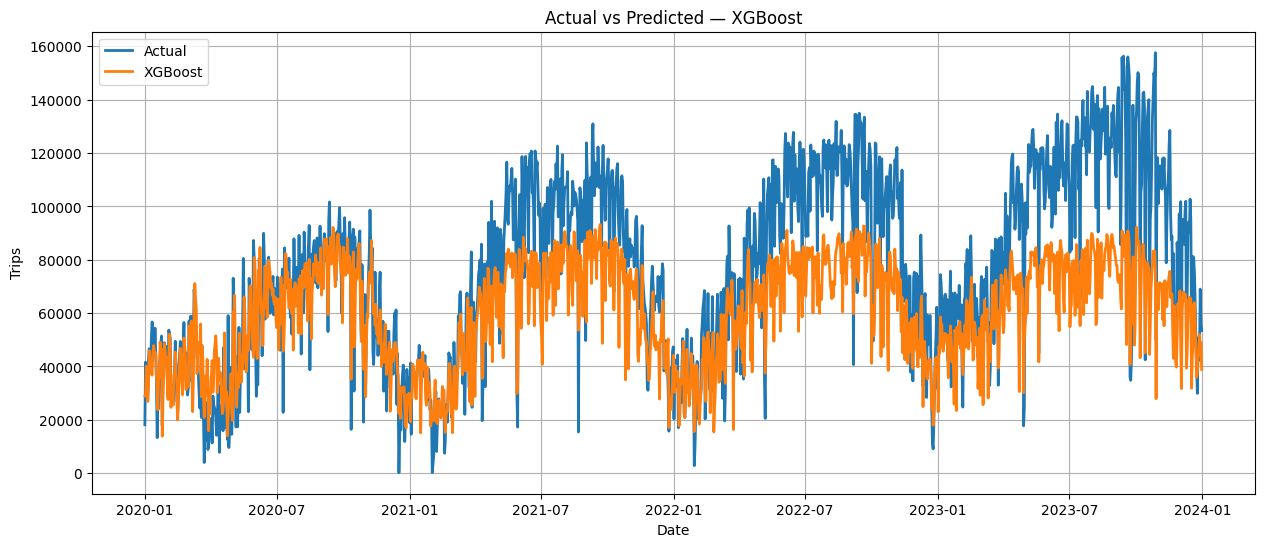

In [ ]:
# 4. Plot: Actual vs Predicted

plt.figure(figsize=(15,6))
plt.plot(test["ds"], y_test, label="Actual", linewidth=2)
plt.plot(test["ds"], test["yhat_xgb"], label="XGBoost", linewidth=2)

plt.title("Actual vs Predicted — XGBoost")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.grid(True)
plt.show()


MAE  : 21858.27
RMSE : 27105.99
R²   : 0.3649


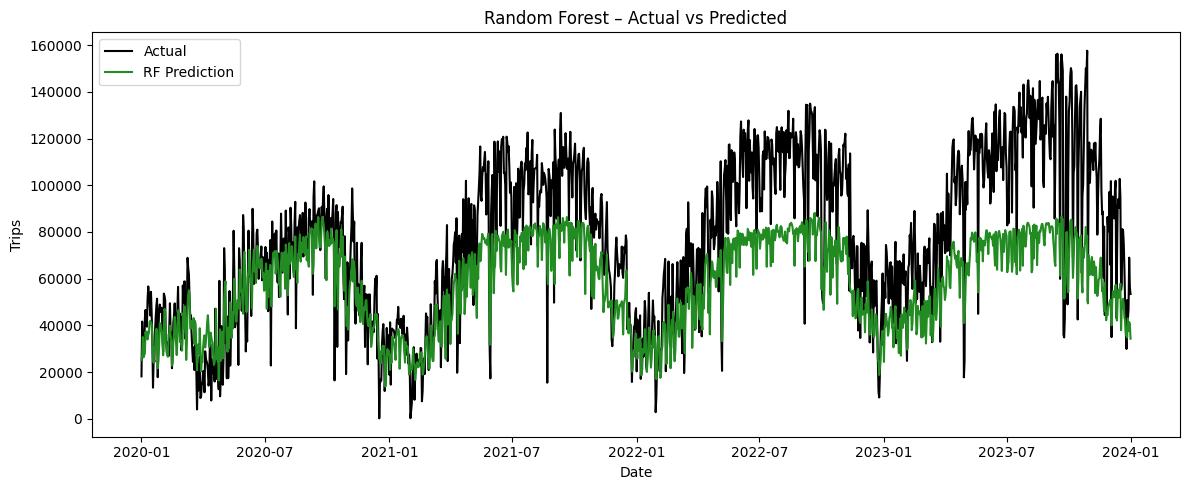

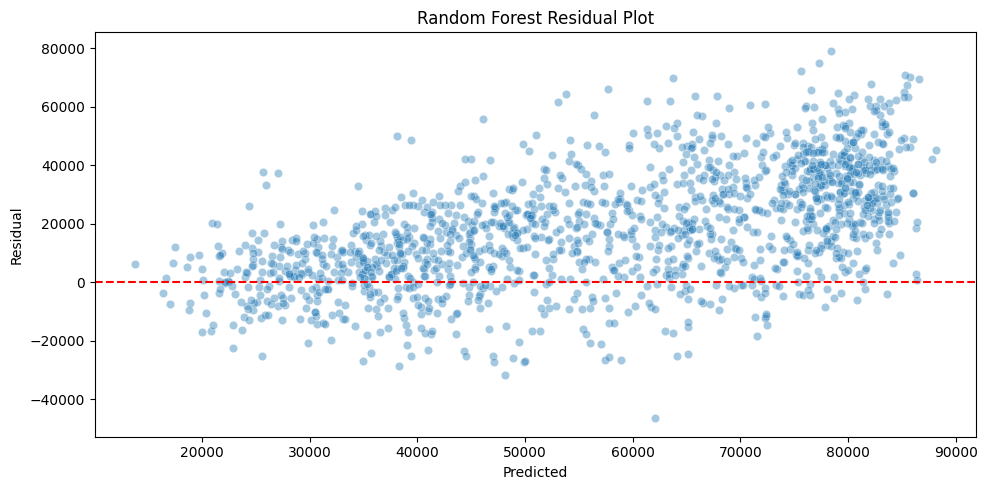

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# 2. Predict
test["yhat_rf"] = rf_model.predict(X_test)


# 3. Metrics
mae  = mean_absolute_error(y_test, test["yhat_rf"])
mse  = mean_squared_error(y_test, test["yhat_rf"])
rmse = mse ** 0.5
r2   = r2_score(y_test, test["yhat_rf"])

print("MAE  :", round(mae, 2))
print("RMSE :", round(rmse, 2))
print("R²   :", round(r2, 4))


# 4. Plot: Actual vs Predicted
plt.figure(figsize=(12, 5))
plt.plot(test["ds"], y_test, label="Actual", color="black")
plt.plot(test["ds"], test["yhat_rf"], label="RF Prediction", color="forestgreen")
plt.title("Random Forest – Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Trips")
plt.legend()
plt.tight_layout()
plt.show()

# 5. Residual Plot
test["residual"] = y_test - test["yhat_rf"]

plt.figure(figsize=(10,5))
sns.scatterplot(x=test["yhat_rf"], y=test["residual"], alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Random Forest Residual Plot")
plt.tight_layout()
plt.show()
